# 03_RL_PPO_LSTM_0522_민영
---
seq_len = 15

In [10]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras import layers, Model

from collections import deque

import warnings
warnings.filterwarnings('ignore')

import pywt #PyWavelets
from pykrx import stock 

# 1) 한글 폰트 지정
plt.rcParams['font.family'] = 'Malgun Gothic'     # Windows
# 2) 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 1. 종목 불러오기

In [11]:
# ──────────────── 종목 불러오기 & 지표 계산 ────────────────

# 1) 관심 종목 리스트 (종목명)
selected_stocks = [ "파미셀", "삼양식품", "이스타코", "코오롱모빌리티그룹우", "오리엔트바이오", "금호전기", "LS에코에너지",
                    "HD현대중공업", "일성건설", "일진전기", "DI동일", "흥국화재우", "대한제강", "유엔젤", "두산" ]
tickers = stock.get_market_ticker_list(market="KOSPI")
filtered_tickers = {stock.get_market_ticker_name(code): code for code in tickers if stock.get_market_ticker_name(code) in selected_stocks}

# 2) 관심 종목의 OHLCV 로드
all_ohlcv = pd.DataFrame()
for name, code in filtered_tickers.items():
    df = stock.get_market_ohlcv_by_date("2024-01-01", "2025-02-28", code)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    all_ohlcv = df if all_ohlcv.empty else all_ohlcv.join(df, how="outer")
all_ohlcv.index.name = "Date"
display(all_ohlcv.tail())

# 3) 가격·거래량 df 추출
price_df  = all_ohlcv.xs("종가",   level=1, axis=1)
volume_df = all_ohlcv.xs("거래량", level=1, axis=1)

'''# 4) 웨이블릿 변환 함수 : 주식 데이터의 노이즈 제거
def wavelet_denoise(series, wavelet='db4', level=2):
    coeff = pywt.wavedec(series, wavelet, mode='periodic')
    # 고주파 성분 제거 (detail 계수 1~level을 0으로 설정)
    coeff[1:] = [np.zeros_like(c) for c in coeff[1:]]
    return pywt.waverec(coeff, wavelet, mode='periodic')[:len(series)]  # 길이 일치'''

# 5) 기술적 지표 계산 (volume_ratio_5d 포함)
def compute_technical_indicators(price, volume):
    ret_5d  = price.pct_change(5)
    rsi_7d  = price.rolling(7).apply(
                lambda x: 100 - 100/(1 + (x.diff().clip(lower=0).sum()/-x.diff().clip(upper=0).sum()))
                if x.diff().clip(upper=0).sum()!=0 else 0,
                raw=False)
    sma_gap_5_10    = (price.rolling(5).mean() - price.rolling(10).mean()) \
                      / price.rolling(10).mean()
    volatility_5d   = price.pct_change().rolling(5).std()
    volume_ratio_5d = volume / volume.rolling(5).mean()
    
    # 웨이블릿으로 종가 denoise 후 새로운 지표 추가
    '''wavelet_filtered = price.apply(wavelet_denoise, axis=0)
    wavelet_ret_5d = wavelet_filtered.pct_change(5)'''

    return {
        'ret_5d':          ret_5d,
        'rsi_7d':          rsi_7d,
        'sma_gap_5_10':    sma_gap_5_10,
        'volatility_5d':   volatility_5d,
        'volume_ratio_5d': volume_ratio_5d
        #'wavelet_ret_5d': wavelet_ret_5d
    }
features_dict = compute_technical_indicators(price_df, volume_df)

# 6) 공통 유효 날짜로 자르기
valid_index = price_df.index
for df in features_dict.values():
    valid_index = valid_index.intersection(df.dropna().index)
for k in features_dict:
    features_dict[k] = features_dict[k].loc[valid_index]

DI동일                                       HD현대중공업          \
               시가     고가     저가     종가    거래량       등락률      시가      고가   
Date                                                                      
2025-02-24  46850  47150  45550  47000  45027  0.000000  306500  310000   
2025-02-25  47000  47150  46050  46900  41920 -0.212766  297000  308500   
2025-02-26  47050  47050  46600  46900  22269  0.000000  311000  313000   
2025-02-27  46950  46950  45750  46750  28620 -0.319829  295000  299500   
2025-02-28  46750  46900  45900  46700  77597 -0.106952  295500  299000   

                            ...    파미셀                           흥국화재우        \
                저가      종가  ...     저가     종가      거래량       등락률    시가    고가   
Date                        ...                                                
2025-02-24  295500  298500  ...  10590  10620  1414545 -6.017699  5050  5050   
2025-02-25  295000  308000  ...  10270  10680   879135  0.564972  5000  5000   
2025-02-26  291500  294000  ...  10540  11130  1455083  4.213483  4950  5050   
2025-02-27  291500  296500  ...  10400  10490  1236271 -5.750225  4970  4985   
2025-02-28  285000  296000  ...   9610  10100  1215167 -3.717827  4970  4970   

                                        
              저가    종가   거래량       등락률  
Date                                    
2025-02-24  5000  5000   336 -0.596421  
2025-02-25  4915  4915  6872 -1.700000  
2025-02-26  4915  4970  7841  1.119023  
2025-02-27  4960  4970  2056  0.000000  
2025-02-28  4935  4950  5628 -0.402414  

[5 rows x 90 columns]

In [13]:
import numpy as np
import pandas as pd

# ===============================================
# Part 2) Environment 클래스 (2채널 공분산 + LSTM 임베딩용)
# ===============================================
class StockEnvironment:
    def __init__(self,
                 price_df,     # in-memory 종가 DataFrame
                 features_dict,   # 기술지표 dict_DataFrames
                 stock_list,              # 관심 종목 리스트
                 embed_model, # FeatureLSTMEmbedder 인스턴스
                 seq_len=15,              # LSTM 시계열 길이
                 mode='train',
                 train_period=('2024-01-01','2024-12-31'),
                 test_period =('2024-12-17','2025-02-28')):
        """
        price_df:     Date × 종목 종가 DataFrame
        features_dict:{지표명: Date × 종목 DataFrame}
        stock_list:  관심 종목 리스트
        embed_model: 기술지표 시계열을 임베딩해줄 모델
        seq_len:      임베딩에 쓸 과거 시계열 길이
        """
        self.stock_list   = stock_list
        self.seq_len      = seq_len
        self.lookback     = seq_len                # 공분산 계산용 윈도우 길이
        self.embed_model  = embed_model            # [수정] 임베딩 모델 추가
        self.mode         = mode

        # 1) 관심 종목만 필터 + 유효 인덱스(휴장일/결측 제거)
        prices = price_df[stock_list].copy()
        idx    = prices.index
        for df in features_dict.values():
            idx = idx.intersection(df.index)
        prices = prices.loc[idx]

        self.features = {
            k: df.loc[idx, stock_list].copy()
            for k, df in features_dict.items()
        }

        # 2) 시계열 분할 (Train / Test)
        train_mask = (prices.index >= train_period[0]) & (prices.index <= train_period[1])
        test_mask  = (prices.index >= test_period[0])  & (prices.index <= test_period[1])

        self.train_prices = prices.loc[train_mask]
        self.test_prices  = prices.loc[test_mask]
        self.train_feats  = {k:df.loc[train_mask] for k,df in self.features.items()}
        self.test_feats   = {k:df.loc[test_mask]  for k,df in self.features.items()}

        # 3) 실행용 데이터 선택
        self._set_data()

    def _set_data(self):
        """mode에 따라 prices/feats 선택 & 인덱스 셋업"""
        if self.mode == 'train':
            self.cur_prices = self.train_prices
            self.cur_feats  = self.train_feats
        else:
            self.cur_prices = self.test_prices
            self.cur_feats  = self.test_feats
            
        self.transaction_cost = 0.0005  # 거래 수수료 (0.05%)    
        self.portfolio_returns = []
        self.n_assets     = len(self.stock_list)
        self.max_step     = len(self.cur_prices) - 1
        self.current_step = self.lookback - 1  # 첫 상태는 index = lookback-1
        self.rebalance_counter = 0           # 리밸런싱 카운터
        self.rebalance_period = 5            # 리밸런싱 주기 (5일마다 리밸런싱)
        
    def reset(self):
        self.rebalance_counter = 0
        self.prev_action = np.ones(self.n_assets) / self.n_assets
        self.portfolio_returns = []

        self._set_data()

        if self.mode == 'test':
            # 테스트 구간에서 lookback 확보 가능한 최소 날짜부터 시작
            if len(self.test_prices) < self.lookback:
                raise ValueError("Test price data is too short for lookback window.")

            self.current_step = self.lookback - 1  # 예: lookback=10 → index 9
        else:
            self.current_step = np.random.randint(self.lookback - 1, self.max_step + 1)

        return self._get_state()



    def _get_state(self):
        start = self.current_step - self.lookback + 1
        end = self.current_step + 1

        if start < 0 or end > len(self.cur_prices):
            raise ValueError(f"Invalid time window: start={start}, end={end}, data_len={len(self.cur_prices)}")

        # 1) 가격 공분산
        window_prices = self.cur_prices.iloc[start:end]
        price_ret     = window_prices.pct_change().dropna()
        price_cov     = price_ret.cov().values

        # 2) 기술지표 시계열 임베딩 벡터 생성
        seqs = []
        for asset in self.stock_list:
            feat_slices = []
            for k in sorted(self.cur_feats.keys()):
                values = self.cur_feats[k][asset].iloc[start:end].values
                if len(values) != self.seq_len:
                    raise ValueError(f"Feature '{k}' for asset '{asset}' has invalid sequence length {len(values)} at step {self.current_step}")
                feat_slices.append(values)

            arr = np.vstack(feat_slices).T  # (seq_len, n_features)
            seqs.append(arr)

        embed_input = np.stack(seqs, axis=0).astype('float32')  # (n_assets, seq_len, n_features)
        emb = self.embed_model(embed_input)
        emb = emb.numpy() if hasattr(emb, 'numpy') else emb

        # 3) 기술지표 기반 공분산
        emb_centered = emb - emb.mean(axis=0, keepdims=True)
        tech_cov     = emb_centered.dot(emb_centered.T) / (self.n_assets - 1)

        # 4) 2채널 스택 & flatten
        cov_stack = np.stack([price_cov, tech_cov], axis=-1)
        flat      = cov_stack.reshape(self.n_assets, -1)

        return flat


    def step(self, action):
        prev_prices = self.cur_prices.iloc[self.current_step].values
        self.current_step += 1

        if self.current_step >= len(self.cur_prices):
            done = True
            next_state = None
            reward = 0
            return next_state, reward, done, {}

        curr_prices = self.cur_prices.iloc[self.current_step].values

        # 수익률 계산
        returns = (curr_prices / prev_prices) - 1
        portfolio_return = np.dot(action, returns)

        # 리밸런싱 시점(=카운터 0)일 때만 수수료 차감
        if self.rebalance_counter == 0:
            turnover    = np.sum(np.abs(action - self.prev_action))
            cost        = self.transaction_cost * turnover
            net_return  = portfolio_return - cost
            self.prev_action = action.copy()
        else:
            net_return = portfolio_return

        self.portfolio_returns.append(net_return)

        # ✅ 리밸런싱 시점이면 출력
        if self.rebalance_counter == 0:
            total_capital = 5e7  # 예시: 총 자산 5천
            quantities = np.floor((action * total_capital) / curr_prices)

            print(f"\n📅 리밸런싱 @ {self.cur_prices.index[self.current_step].date()}")
            for stock, weight, price, qty in zip(self.stock_list, action, curr_prices, quantities):
                print(f"  {stock:<12} | 비중: {weight:.2%} | 가격: {price:,.0f} | 수량: {int(qty)}주")

        # ✅ 누적 수익률 기록
        if not hasattr(self, 'portfolio_returns'):
            self.portfolio_returns = []
        self.portfolio_returns.append(portfolio_return)

        # ✅ 보상: 샤프비율로 계산
        N = 5  # 최근 5일 기준
        if len(self.portfolio_returns) >= N:
            recent = self.portfolio_returns[-N:]
            mean_ret = np.mean(recent)
            std_ret = np.std(recent) + 1e-8  # 0 나눗셈 방지
            reward = mean_ret / std_ret
        else:
            reward = 0

        next_state = self._get_state()
        done = False
        self.rebalance_counter = (self.rebalance_counter + 1) % self.rebalance_period
        return next_state, reward, done, {}



In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# ===============================================
# Part 3) PPOAgent 클래스 (2채널 공분산용)
# ===============================================
class PPOAgent:
    def __init__(self,          
                 n_assets,          # len(stock_list)
                 cov_size,          # n_assets * 2
                 actor_lr=3e-4,     # Actor 학습률
                 critic_lr=1e-3,    # Critic 학습률
                 gamma=0.99,        # 할인계수
                 clip_ratio=0.2,    # PPO clipping 비율
                 update_steps=10    # PPO 업데이트 스텝 수
                 ):
        """
        n_assets:   종목 수
        cov_size:   각 자산별 feature 수 (n_assets*2)
        """
        self.n_assets     = n_assets
        self.cov_size     = cov_size
        self.gamma        = gamma
        self.clip_ratio   = clip_ratio
        self.update_steps = update_steps

        # Actor & Critic 네트워크 생성
        self.actor  = self._build_actor()    # 확률 분포 반환
        self.critic = self._build_critic()   # 상태 가치 반환

        # 옵티마이저
        self.actor_opt  = tf.keras.optimizers.Adam(actor_lr)
        self.critic_opt = tf.keras.optimizers.Adam(critic_lr)

        # PPO 버퍼
        self.states    = []  # list of tf.Tensor shape=(1,n_assets,cov_size)
        self.actions   = []  # list of np.ndarray shape=(n_assets,)
        self.rewards   = []  # list of float
        self.values    = []  # list of float
        self.log_probs = []  # list of tf.Tensor shape=(n_assets,)

    # Actor & Critic 네트워크 정의
    def _build_actor(self):
        inp = layers.Input(shape=(self.n_assets, self.cov_size))
        x   = layers.Flatten()(inp)
        x   = layers.Dense(128, activation='relu')(x)
        x   = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(self.n_assets, activation='softmax')(x)
        model = Model(inp, out)
        return model
    
    def _build_critic(self):
        inp = layers.Input(shape=(self.n_assets, self.cov_size))
        x   = layers.Flatten()(inp)
        x   = layers.Dense(128, activation='relu')(x)
        x   = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(1, activation='linear')(x)
        model = Model(inp, out)
        return model


    def select_action(self, state):
        """
        state: np.ndarray shape=(n_assets, cov_size)
        return: action(np.ndarray), value(float)
        """
        state_tf = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
        # 1) Actor
        probs = tf.squeeze(self.actor(state_tf), axis=0)    # shape=(n_assets,)
        action = probs.numpy()
        # 2) Critic
        value  = float(tf.squeeze(self.critic(state_tf), axis=0))

        # 3) Log-prob for PPO
        log_prob = tf.math.log(probs + 1e-8)                # shape=(n_assets,)

        # 버퍼에 저장
        self.states.append(state_tf)
        self.actions.append(action)
        self.values.append(value)
        self.log_probs.append(log_prob)

        return action, value

    def store_reward(self, reward):
        self.rewards.append(float(reward))

    def train(self):
        # 1) 할인 보상 계산
        returns = []
        G = 0
        for r in reversed(self.rewards):    
            G = r + self.gamma * G
            returns.insert(0, G)
        returns   = tf.convert_to_tensor(returns, dtype=tf.float32)       # (T,)
        values    = tf.convert_to_tensor(self.values, dtype=tf.float32)  # (T,)
        log_probs = tf.stack(self.log_probs, axis=0)                     # (T, n_assets)
        advantages = returns - values                                     # (T,)

        # 배치 상태
        states_batched = tf.concat(self.states, axis=0)                   # (T, n_assets, cov_size)

        # 2) Actor 업데이트
        for _ in range(self.update_steps):
            with tf.GradientTape() as tape:
                new_probs    = self.actor(states_batched)                # (T, n_assets)
                new_log_probs= tf.math.log(new_probs + 1e-8)
                ratio        = tf.exp(new_log_probs - log_probs)         # (T, n_assets)
                adv_expanded = tf.expand_dims(advantages, axis=1)        # (T,1)
                surr1 = ratio * adv_expanded
                surr2 = tf.clip_by_value(ratio,
                                        1-self.clip_ratio,
                                        1+self.clip_ratio) * adv_expanded
                actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
            grads = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_opt.apply_gradients(zip(grads, self.actor.trainable_variables))

        # 3) Critic 업데이트
        for _ in range(self.update_steps):
            with tf.GradientTape() as tape:
                value_preds = tf.squeeze(self.critic(states_batched), axis=1)  # (T,)
                critic_loss = tf.reduce_mean((returns - value_preds)**2)
            grads = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

        # 4) 버퍼 초기화
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.log_probs.clear()


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ───────────LSTM 임베딩 클래스 ──────────────── #
class FeatureLSTMEmbedder(Model):
    def __init__(self, lstm_units=16, output_dim=8):
        super().__init__()
        self.lstm = layers.LSTM(
            lstm_units,
            return_sequences=False,
            input_shape=(None, None)  # 실제 입력은 (seq_len, n_features)
        )
        self.dense = layers.Dense(output_dim, activation='relu')

    def call(self, x):
        """
        x: tf.Tensor or np.ndarray of shape (n_assets, seq_len, n_features)
        returns: tf.Tensor of shape (n_assets, output_dim)
        """
        embeddings = []
        for asset_seq in tf.unstack(x, axis=0):  # asset_seq: (seq_len, n_features)
            h = self.lstm(tf.expand_dims(asset_seq, 0))  # (1, lstm_units)
            emb = self.dense(h)                           # (1, output_dim)
            embeddings.append(tf.squeeze(emb, axis=0))    # (output_dim,)
        return tf.stack(embeddings, axis=0)              # (n_assets, output_dim)


# Train
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pykrx import stock

# ===============================================
# Part 4) 학습(Train) 루프
# ===============================================

# 0) KOSPI200 ETF 종가 불러오기
etf_ohlcv = stock.get_market_ohlcv_by_date(
    "2024-01-01", "2024-12-31", "069500"  # KODEX 200 ETF
)["종가"]

# 1) Train 환경 & 에이전트 준비
feature_embedder = FeatureLSTMEmbedder(lstm_units=16, output_dim=8)  # [수정] 임베딩 모델

env_train = StockEnvironment(
    price_df,                # in-memory 종가 DataFrame
    features_dict,           # 기술지표 dict
    selected_stocks,
    feature_embedder,        # embed_model 전달
    seq_len=15,
    mode='train'
)

# ETF 시리즈를 env_train의 날짜 인덱스에 맞춰 재색인
etf_series = etf_ohlcv.reindex(env_train.cur_prices.index)

agent = PPOAgent(
    n_assets=len(selected_stocks),
    cov_size=len(selected_stocks) * 2   # 2채널 공분산
)

# 2) 하이퍼파라미터
episode_count = 50
print_every   = 5

# 3) 에피소드 반복
for ep in range(1, episode_count + 1):
    state = env_train.reset()      # [수정] reset() → state
    done  = False
    ep_rewards = []
    ep_etf_ret = []

    # 초기 ETF 날짜
    last_date = env_train.cur_prices.index[env_train.current_step]

    while not done:
        # 1) 행동 선택
        action, _ = agent.select_action(state)

        # 2) 환경 한 스텝 진행
        next_state, reward, done, _ = env_train.step(action)

        # 3) reward 저장
        agent.store_reward(reward)
        ep_rewards.append(reward)

        # 4) ETF reward 계산
        if env_train.current_step >= len(env_train.cur_prices.index):
            break
        current_date = env_train.cur_prices.index[env_train.current_step]

        etf_r = (etf_series.loc[current_date] / etf_series.loc[last_date]) - 1
        ep_etf_ret.append(etf_r)
        last_date = current_date

        state = next_state

    # 5) 에피소드 종료 후 PPO 업데이트
    agent.train()

    # 6) 로그 및 시각화
    if ep % print_every == 0:
        cum_rl  = np.cumsum(ep_rewards)
        cum_etf = np.cumsum(ep_etf_ret)

        print(f"[Episode {ep}/{episode_count}] Total RL Return: {cum_rl[-1]:.4f}, "
              f"ETF Return: {cum_etf[-1]:.4f}")

        plt.figure(figsize=(8, 3))
        plt.plot(cum_rl,  label="PPO Portfolio")
        plt.plot(cum_etf, label="KOSPI200 ETF", linestyle="--")
        plt.title(f"Episode {ep} Cumulative Return")
        plt.xlabel("Step")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.tight_layout()
        plt.show()


# Test
---


📅 리밸런싱 @ 2025-01-10
  파미셀          | 비중: 1.31% | 가격: 8,940 | 수량: 73주
  삼양식품         | 비중: 24.50% | 가격: 750,000 | 수량: 16주
  이스타코         | 비중: 1.65% | 가격: 1,783 | 수량: 462주
  코오롱모빌리티그룹우   | 비중: 1.59% | 가격: 6,700 | 수량: 118주
  오리엔트바이오      | 비중: 1.36% | 가격: 1,851 | 수량: 367주
  금호전기         | 비중: 1.07% | 가격: 1,262 | 수량: 424주
  LS에코에너지      | 비중: 1.12% | 가격: 37,500 | 수량: 14주
  HD현대중공업      | 비중: 1.60% | 가격: 314,000 | 수량: 2주
  일성건설         | 비중: 2.43% | 가격: 4,330 | 수량: 280주
  일진전기         | 비중: 3.05% | 가격: 27,850 | 수량: 54주
  DI동일         | 비중: 1.87% | 가격: 49,100 | 수량: 19주
  흥국화재우        | 비중: 2.00% | 가격: 5,310 | 수량: 188주
  대한제강         | 비중: 12.54% | 가격: 15,960 | 수량: 392주
  유엔젤          | 비중: 2.24% | 가격: 4,890 | 수량: 228주
  두산           | 비중: 41.67% | 가격: 289,500 | 수량: 71주


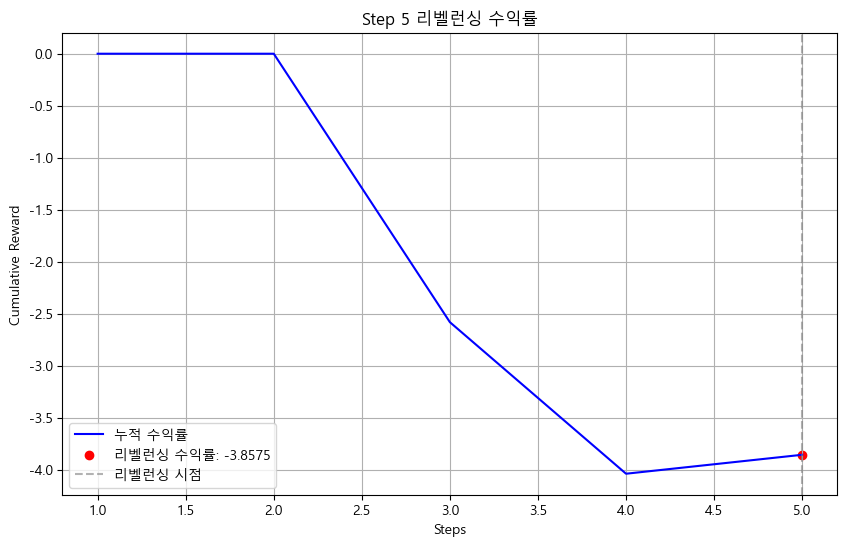


📅 리밸런싱 @ 2025-01-17
  파미셀          | 비중: 2.47% | 가격: 8,440 | 수량: 146주
  삼양식품         | 비중: 20.13% | 가격: 762,000 | 수량: 13주
  이스타코         | 비중: 2.95% | 가격: 1,337 | 수량: 1103주
  코오롱모빌리티그룹우   | 비중: 2.89% | 가격: 6,610 | 수량: 218주
  오리엔트바이오      | 비중: 2.57% | 가격: 1,330 | 수량: 965주
  금호전기         | 비중: 2.15% | 가격: 880 | 수량: 1221주
  LS에코에너지      | 비중: 2.24% | 가격: 50,800 | 수량: 22주
  HD현대중공업      | 비중: 2.91% | 가격: 310,000 | 수량: 4주
  일성건설         | 비중: 3.78% | 가격: 3,420 | 수량: 552주
  일진전기         | 비중: 4.41% | 가격: 31,350 | 수량: 70주
  DI동일         | 비중: 3.21% | 가격: 49,950 | 수량: 32주
  흥국화재우        | 비중: 3.41% | 가격: 5,200 | 수량: 327주
  대한제강         | 비중: 12.34% | 가격: 16,530 | 수량: 373주
  유엔젤          | 비중: 3.62% | 가격: 5,120 | 수량: 353주
  두산           | 비중: 30.92% | 가격: 285,500 | 수량: 54주


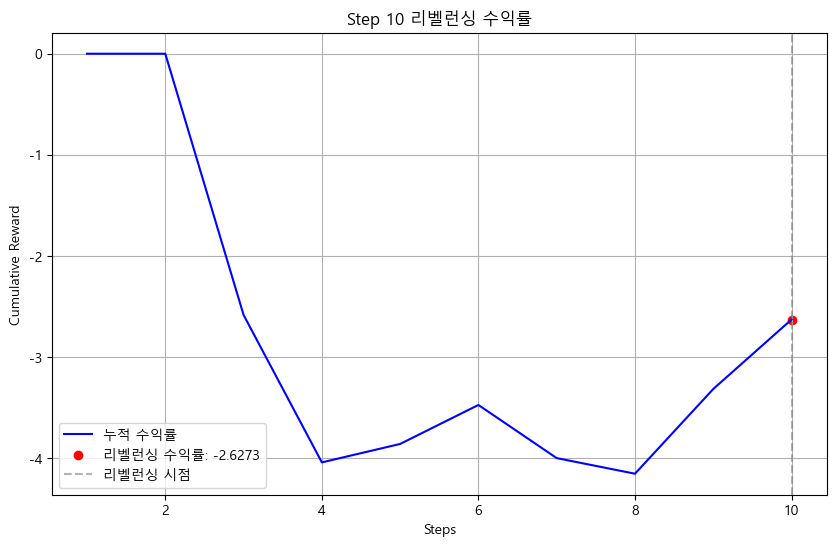


📅 리밸런싱 @ 2025-01-24
  파미셀          | 비중: 1.80% | 가격: 9,170 | 수량: 98주
  삼양식품         | 비중: 22.77% | 가격: 710,000 | 수량: 16주
  이스타코         | 비중: 2.26% | 가격: 1,278 | 수량: 883주
  코오롱모빌리티그룹우   | 비중: 2.14% | 가격: 5,650 | 수량: 189주
  오리엔트바이오      | 비중: 1.88% | 가격: 1,455 | 수량: 646주
  금호전기         | 비중: 1.54% | 가격: 869 | 수량: 883주
  LS에코에너지      | 비중: 1.57% | 가격: 46,700 | 수량: 16주
  HD현대중공업      | 비중: 2.17% | 가격: 301,500 | 수량: 3주
  일성건설         | 비중: 3.12% | 가격: 3,155 | 수량: 493주
  일진전기         | 비중: 3.76% | 가격: 36,250 | 수량: 51주
  DI동일         | 비중: 2.50% | 가격: 50,000 | 수량: 24주
  흥국화재우        | 비중: 2.64% | 가격: 4,960 | 수량: 265주
  대한제강         | 비중: 12.78% | 가격: 16,550 | 수량: 386주
  유엔젤          | 비중: 2.92% | 가격: 5,420 | 수량: 269주
  두산           | 비중: 36.15% | 가격: 332,500 | 수량: 54주


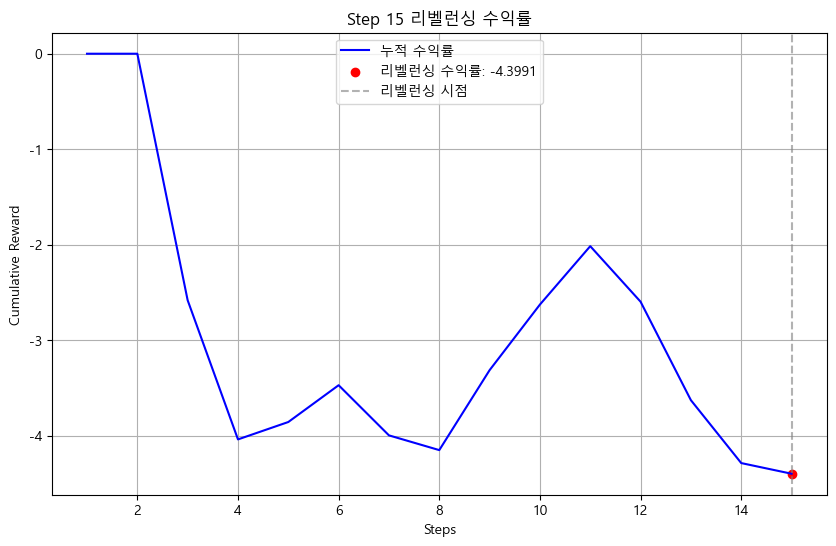


📅 리밸런싱 @ 2025-02-06
  파미셀          | 비중: 1.59% | 가격: 8,790 | 수량: 90주
  삼양식품         | 비중: 23.72% | 가격: 809,000 | 수량: 14주
  이스타코         | 비중: 1.98% | 가격: 1,258 | 수량: 787주
  코오롱모빌리티그룹우   | 비중: 1.89% | 가격: 4,875 | 수량: 194주
  오리엔트바이오      | 비중: 1.64% | 가격: 1,425 | 수량: 574주
  금호전기         | 비중: 1.31% | 가격: 882 | 수량: 744주
  LS에코에너지      | 비중: 1.37% | 가격: 44,750 | 수량: 15주
  HD현대중공업      | 비중: 1.90% | 가격: 303,000 | 수량: 3주
  일성건설         | 비중: 2.82% | 가격: 3,080 | 수량: 458주
  일진전기         | 비중: 3.47% | 가격: 34,000 | 수량: 51주
  DI동일         | 비중: 2.22% | 가격: 48,650 | 수량: 22주
  흥국화재우        | 비중: 2.37% | 가격: 5,010 | 수량: 236주
  대한제강         | 비중: 12.82% | 가격: 15,610 | 수량: 410주
  유엔젤          | 비중: 2.58% | 가격: 4,885 | 수량: 264주
  두산           | 비중: 38.31% | 가격: 289,000 | 수량: 66주


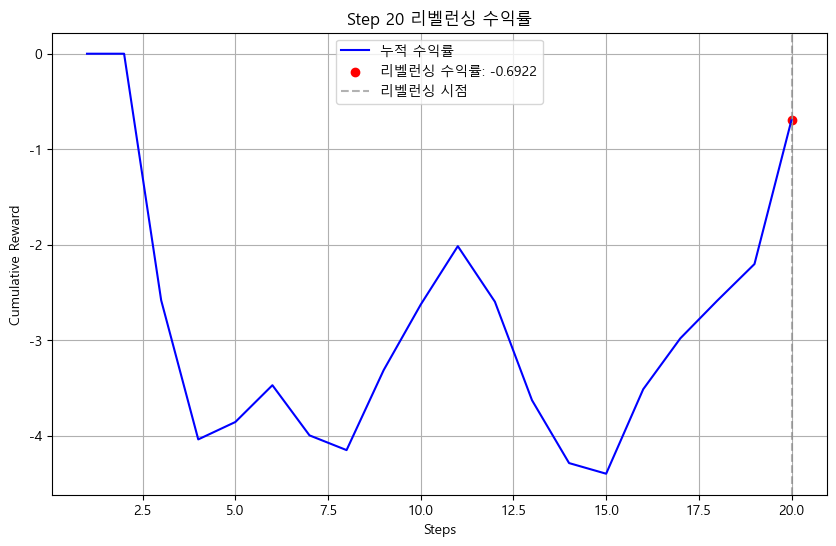


📅 리밸런싱 @ 2025-02-13
  파미셀          | 비중: 2.28% | 가격: 10,820 | 수량: 105주
  삼양식품         | 비중: 21.13% | 가격: 803,000 | 수량: 13주
  이스타코         | 비중: 2.77% | 가격: 1,313 | 수량: 1055주
  코오롱모빌리티그룹우   | 비중: 2.69% | 가격: 4,350 | 수량: 308주
  오리엔트바이오      | 비중: 2.37% | 가격: 1,522 | 수량: 778주
  금호전기         | 비중: 1.98% | 가격: 839 | 수량: 1180주
  LS에코에너지      | 비중: 2.05% | 가격: 42,000 | 수량: 24주
  HD현대중공업      | 비중: 2.67% | 가격: 366,000 | 수량: 3주
  일성건설         | 비중: 3.63% | 가격: 3,170 | 수량: 573주
  일진전기         | 비중: 4.33% | 가격: 33,800 | 수량: 64주
  DI동일         | 비중: 3.04% | 가격: 47,600 | 수량: 31주
  흥국화재우        | 비중: 3.19% | 가격: 5,070 | 수량: 314주
  대한제강         | 비중: 12.63% | 가격: 15,030 | 수량: 420주
  유엔젤          | 비중: 3.47% | 가격: 5,110 | 수량: 339주
  두산           | 비중: 31.75% | 가격: 330,000 | 수량: 48주


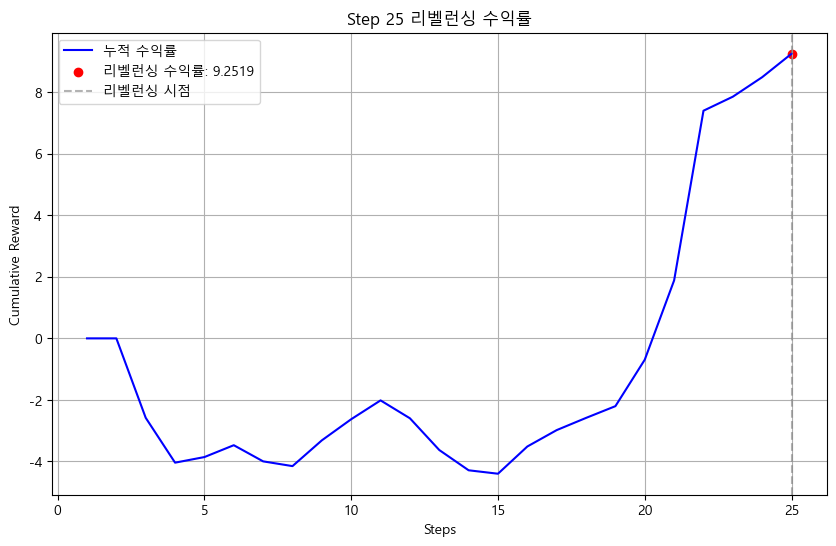


📅 리밸런싱 @ 2025-02-20
  파미셀          | 비중: 2.71% | 가격: 10,830 | 수량: 125주
  삼양식품         | 비중: 19.54% | 가격: 880,000 | 수량: 11주
  이스타코         | 비중: 3.21% | 가격: 1,365 | 수량: 1174주
  코오롱모빌리티그룹우   | 비중: 3.13% | 가격: 4,290 | 수량: 364주
  오리엔트바이오      | 비중: 2.81% | 가격: 1,620 | 수량: 865주
  금호전기         | 비중: 2.39% | 가격: 799 | 수량: 1493주
  LS에코에너지      | 비중: 2.47% | 가격: 39,250 | 수량: 31주
  HD현대중공업      | 비중: 3.12% | 가격: 305,500 | 수량: 5주
  일성건설         | 비중: 4.04% | 가격: 3,085 | 수량: 654주
  일진전기         | 비중: 4.75% | 가격: 30,800 | 수량: 77주
  DI동일         | 비중: 3.50% | 가격: 45,450 | 수량: 38주
  흥국화재우        | 비중: 3.63% | 가격: 5,020 | 수량: 361주
  대한제강         | 비중: 12.26% | 가격: 15,300 | 수량: 400주
  유엔젤          | 비중: 3.92% | 가격: 5,280 | 수량: 371주
  두산           | 비중: 28.52% | 가격: 342,500 | 수량: 41주


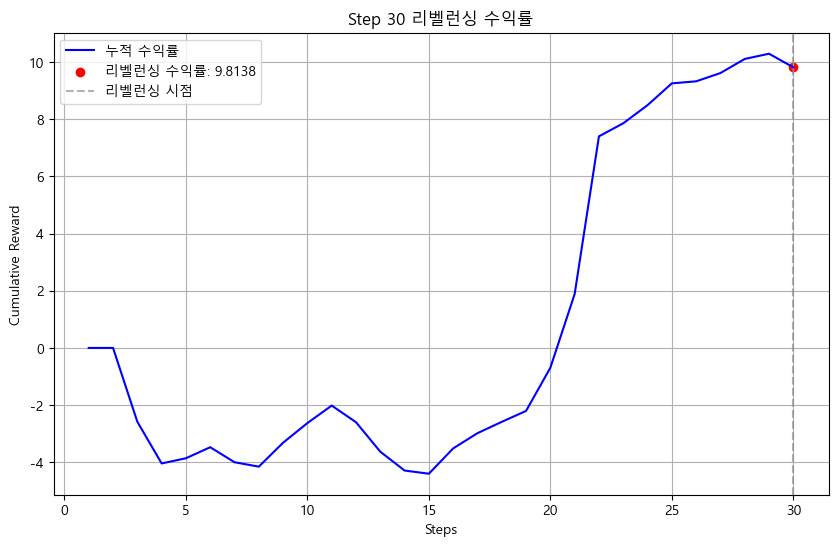


📅 리밸런싱 @ 2025-02-27
  파미셀          | 비중: 2.70% | 가격: 10,490 | 수량: 128주
  삼양식품         | 비중: 19.51% | 가격: 884,000 | 수량: 11주
  이스타코         | 비중: 3.19% | 가격: 1,700 | 수량: 938주
  코오롱모빌리티그룹우   | 비중: 3.12% | 가격: 4,510 | 수량: 345주
  오리엔트바이오      | 비중: 2.78% | 가격: 1,667 | 수량: 834주
  금호전기         | 비중: 2.37% | 가격: 756 | 수량: 1565주
  LS에코에너지      | 비중: 2.47% | 가격: 38,350 | 수량: 32주
  HD현대중공업      | 비중: 3.12% | 가격: 296,500 | 수량: 5주
  일성건설         | 비중: 4.03% | 가격: 3,310 | 수량: 608주
  일진전기         | 비중: 4.74% | 가격: 29,300 | 수량: 80주
  DI동일         | 비중: 3.50% | 가격: 46,750 | 수량: 37주
  흥국화재우        | 비중: 3.64% | 가격: 4,970 | 수량: 365주
  대한제강         | 비중: 12.23% | 가격: 15,810 | 수량: 386주
  유엔젤          | 비중: 3.90% | 가격: 5,550 | 수량: 351주
  두산           | 비중: 28.71% | 가격: 354,500 | 수량: 40주


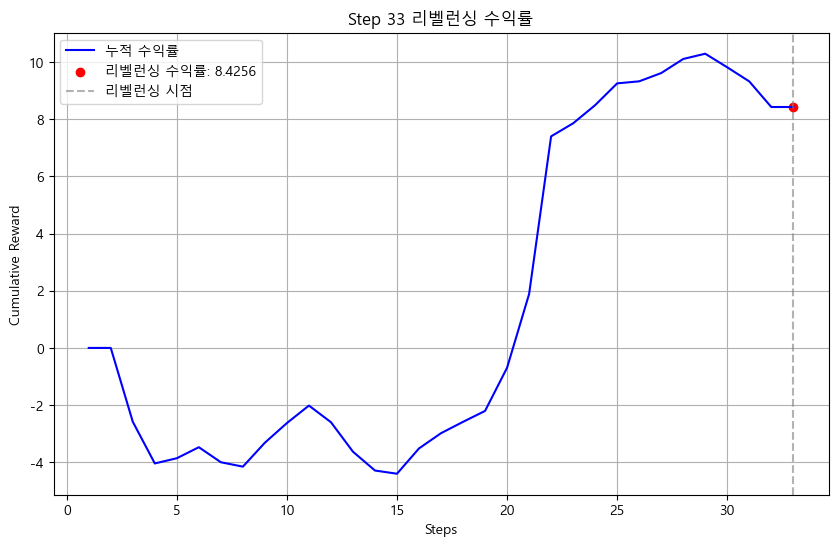

테스트 횟수: 1
최종 누적 수익률: 8.4256


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 파라미터 설정
rebalance_period = 5  # 리벨런싱 주기
total_steps = 33      # 총 스텝
num_tests = 1         # 테스트 횟수

# 결과 저장용 리스트
cum_returns = []  # 최종 누적 수익률 저장
step_returns = []  # 각 리벨런싱 단계별 수익률 저장

for i in range(num_tests):
    # 테스트 환경 초기화
    env_test = StockEnvironment(
        price_df,
        features_dict,
        selected_stocks,
        feature_embedder,
        seq_len=15,
        mode='test'
    )

    state = env_test.reset()
    done = False
    test_rewards = []
    last_date = env_test.cur_prices.index[env_test.current_step]
    step_count = 0  # 현재 스텝 수 초기화
    cumulative_reward = 0  # 누적 수익률 초기화

    # 에피소드 실행
    while not done and step_count < total_steps:
        action, _ = agent.select_action(state)
        next_state, reward, done, _ = env_test.step(action)
        test_rewards.append(reward)
        cumulative_reward += reward
        step_count += 1

        if not done:
            state = next_state
            current_date = env_test.cur_prices.index[env_test.current_step]

            # ETF 성과 비교(필요시)
            try:
                etf_r = (etf_series.loc[current_date] / etf_series.loc[last_date]) - 1
            except KeyError:
                etf_r = 0
            last_date = current_date

        # 리벨런싱 단계에서 그래프 업데이트
        if step_count % rebalance_period == 0 or done:
            cum_rl = np.cumsum(test_rewards)
            step_return = cum_rl[-1]
            step_returns.append(step_return)

            # 그래프 그리기
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, step_count + 1), cum_rl, label="누적 수익률", color="blue")
            plt.scatter(step_count, step_return, color="red", label=f"리벨런싱 수익률: {step_return:.4f}")
            plt.axvline(step_count, linestyle="--", color="gray", alpha=0.6, label="리벨런싱 시점")
            plt.title(f"Step {step_count} 리벨런싱 수익률")
            plt.xlabel("Steps")
            plt.ylabel("Cumulative Reward")
            plt.legend()
            plt.grid()
            plt.show()

    # 이 에피소드의 최종 누적 수익률 기록
    cum_rl = np.cumsum(test_rewards)
    cum_returns.append(cum_rl[-1])

# 요약 통계 출력
print(f"테스트 횟수: {num_tests}")
print(f"최종 누적 수익률: {cum_returns[-1]:.4f}")


In [2]:
5e7*1.084256

54212800.00000001